# Tutorial 3: Advance MIP in Python$^{*}$

<img src="win.png" width="500">

## Table of contents
1. [Recap](#recap)
2. [Termination Criteria](#termination)
3. [Travelling Salesman Problem](#tsp)
4. [Optimization and Heuristics](#heuristics)

<p></p>
<b>$^{*}$Most material of this notebook is sourced from the following resource:</b><br>
$^{1}$ gurobi.com<br>

***

# 1. Recap<a name="recap"></a>

<p><strong>Problem Statement</strong>:</p>
<p>A company currently ships its product from 6 plants&nbsp;to 10 warehouses. It is considering closing some plants to reduce&nbsp;costs. What plant(s) should the company close, in order to minimize&nbsp;transportation and fixed costs?</p>
<p><strong>What we know?</strong></p>
<ul>
<li># of Plants: 4</li>
<li># of warehouse: 10</li>
<li>A plant can ship to any of the 10 warehouses</li>
<li>Fixed cost to run each of the plant is given</li>
<li>Transportation cost for a plant to warehouse is given</li>
</ul>
<p><strong>Reference</strong>: http://www.solver.com/disfacility.htm</p>

### Step 1: Import functions from the gurobipy module

In [1]:
from gurobipy import *


### Step 2: Create empty model

In [2]:
m = Model("facility")

Academic license - for non-commercial use only


### Step 3: Create activitiy variables

#### Step 3a: Defining/Gathering data

In [3]:
# Warehouse demand in thousands of units
demand = [15, 18, 14, 20, 22, 19, 20, 19, 19, 20]

# Plant capacity in thousands of units
capacity = [39, 38, 38, 37, 36, 38]

# Fixed costs for each plant
fixedCosts = [12000, 15000, 15000, 13000, 16200, 16000]

# Range of plants and warehouses
plants = range(len(capacity))
warehouses = range(len(demand))

import pandas as pd
import numpy as np
transCosts=np.array(pd.read_csv("data.csv",index_col=0))

#### Step 3b: Create activitiy variables

In [4]:
# Plant open decision variables: open[p] == 1 if plant p is open.

open = m.addVars(plants,
                 vtype=GRB.BINARY,
                 name="open")

# Transportation decision variables: transport[w,p] captures the
# optimal quantity to transport to warehouse w from plant p

transport = m.addVars(warehouses, plants, name="trans")

### Step 4: Set objective function

In [5]:
# The objective is to minimize the total fixed and variable costs
m.setObjective(quicksum(open[i]*fixedCosts[i] for i in plants)+\
               quicksum(transCosts[j,i]*transport[j,i] for j in warehouses for i in plants), GRB.MINIMIZE)

### Step 5: Add constraints

In [6]:
# Production constraints
# Note that the right-hand limit sets the production to zero if the plant
# is closed
m.addConstrs(
    (transport.sum('*',p) <= capacity[p]*open[p] for p in plants),
    "Capacity")

# Demand constraints
m.addConstrs(
    (transport.sum(w,'*') >= demand[w] for w in warehouses),
    "Demand")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>}

### Step 6: Solve model

#### Writing Model </u>

In [7]:
# Save model
m.write('facility.lp')

#### Defining initial starting point</u>

In [8]:
# First, open all plants
for p in plants:
    open[p].start = 1.0

# Now close the plant with the highest fixed cost
print('Initial guess:')
open[4].start = 0.0
print('Closing plant %s' % p)
print('')

Initial guess:
Closing plant 5



In [9]:
m.optimize()

Optimize a model with 16 rows, 66 columns and 126 nonzeros
Variable types: 60 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+01]

Loaded MIP start with objective 522200

Presolve removed 1 rows and 6 columns
Presolve time: 0.00s
Presolved: 15 rows, 60 columns, 114 nonzeros
Variable types: 54 continuous, 6 integer (6 binary)

Root relaxation: objective 4.842973e+05, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 484297.297    0    1 522200.000 484297.297  7.26%     -    0s
H    0     0                    485000.00000 484297.297  0.14%     -    0s
     0     0     cutoff    0      485000.000 485000.000  0.00%     -    0s

Explored 1 nodes (24 simplex iterations) in 0.08 seconds
Thread count was 4 (of 4 av

### Step 7: Print variable values for optimal solution

In [10]:
# Print solution
print('\nTOTAL COSTS: %g' % m.objVal)
print('SOLUTION:')
for p in plants:
    if open[p].x > 0.99:
        print('Plant %s open' % p)
        for w in warehouses:
            if transport[w,p].x > 0:
                print('  Transport %g units to warehouse %s' % \
                      (transport[w,p].x, w))
    else:
        print('Plant %s closed! Bang bang, my baby shot me down!' % p)


TOTAL COSTS: 485000
SOLUTION:
Plant 0 open
  Transport 14 units to warehouse 2
  Transport 5 units to warehouse 3
  Transport 20 units to warehouse 6
Plant 1 open
  Transport 15 units to warehouse 0
  Transport 15 units to warehouse 3
  Transport 8 units to warehouse 4
Plant 2 closed! Bang bang, my baby shot me down!
Plant 3 open
  Transport 18 units to warehouse 1
  Transport 14 units to warehouse 4
  Transport 3 units to warehouse 9
Plant 4 open
  Transport 19 units to warehouse 7
  Transport 17 units to warehouse 9
Plant 5 open
  Transport 19 units to warehouse 5
  Transport 19 units to warehouse 8


## NEW TOPIC: Sensitivity Analysis in MIP

In [11]:
# Store the optimal solution

origObjVal = m.ObjVal
for v in m.getVars():
    v._origX = v.X
print(origObjVal)
# Disable solver output for subsequent solves

m.Params.outputFlag = 0

# Iterate through unfixed, binary variables in model

for v in m.getVars():
    if (v.VType == GRB.BINARY or v.VType == GRB.INTEGER):

        # Set variable to 1-X, where X is its value in optimal solution

        if v._origX < 0.5:
            v.LB = v.Start = 1
        else:
            v.UB = v.Start = 0

        # Update MIP start for the other variables

        for vv in m.getVars():
            if not vv.sameAs(v):
                vv.Start = vv._origX

        # Solve for new value and capture sensitivity information
        m.optimize()

        print('Objective sensitivity for variable %s is %g' % \
              (v.VarName, m.ObjVal))

        # Restore the original variable bounds

        v.LB = 0
        v.UB = 1

485000.0
Objective sensitivity for variable open[0] is 533400
Objective sensitivity for variable open[1] is 512400
Objective sensitivity for variable open[2] is 495100
Objective sensitivity for variable open[3] is 495100
Objective sensitivity for variable open[4] is 522200
Objective sensitivity for variable open[5] is 500100


# 2. Controlling Termination Criteria and MIP Focus <a name="termination"></a>

In [12]:
from gurobipy import *
m = Model()

<ul>
    <li>Controlling MIP focus:
    <ul>
        <li><code>m.setParam('MIPFocus',1)</code>: Focus on finding good solutions</li> 
        <li><code>m.setParam('MIPFocus',2)</code>: Focus on proving optimality</li>
        <li><code>m.setParam('MIPFocus',3)</code>: Focus on improving lower bound</li>
        <li><code>m.setParam('Heuristics',0.5)</code> Ask Gurobi to spend about 50% of the time looking for improving solutions</li>
    </ul></li>
 </ul>

<ul>
    <li>Setting an acceptable proven gap: We can set both a maximum relative or absolute <span class="blue bold">gap</span>
    <ul>
        <li><code>m.setParam('MIPGap',0.1)</code>: Stop if <span class="blue bold">proven</span> gap is under 10% </li>
        <li><code>m.setParam('MIPGapAbs',1.0)</code>: Stop if <span class="blue bold">proven</span> gap is under 1.0</li>
        <li><code>m.setParam('Cutoff',maxval)</code>: Don't explore nodes whose LP value is above <code>maxval</code></li>
        <li><code>m.setParam('BestObjStop',targetval)</code>: Stop whenever we find a solution with value under <code>targetval</code></li>
        <li><code>m.setParam('BestBdStop',relaxval)</code>: Stop whenever the current bound value is above <code>relaxval</code></li>
    </ul></li>
</ul>

<ul>
    <li>Limiting how much work to perform during a MIP solve:
    <ul>
        <li><code>m.setParam('SolutionLimit',5)</code>: Stop after finding <code>5</code> solutions. The larger the number, the better the quality... but longer to find</li>
        <li><code>m.setParam('NodeLimit',500)</code>: Stop after exploring <code>500</code> nodes in Branch and Bound</li>
        <li><code>m.setParam('IterationLimit',1000000)</code>: Stop after performing <code>1000000</code> simplex iterations</li>
        <li><code>m.setParam('TimeLimit',3600)</code>: Stop after an hour of running time</li>
    </ul></li>
    
</ul>

# 3. Travelling Salesman Problem <a name="tsp"></a>

<p><strong>Problem Statement</strong>:</p>
<p>"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?" It is an <a title="NP-hardness" href="https://en.wikipedia.org/wiki/NP-hardness">NP-hard</a> problem in <a title="Combinatorial optimization" href="https://en.wikipedia.org/wiki/Combinatorial_optimization">combinatorial optimization</a>, important in <a title="Operations research" href="https://en.wikipedia.org/wiki/Operations_research">operations research</a> and <a title="Theoretical computer science" href="https://en.wikipedia.org/wiki/Theoretical_computer_science">theoretical computer science</a>.</p>

In [13]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="700" height="450" src="https://www.youtube.com/embed/l8KBKItQ3T4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<img src="tsp.png" width="400">

<p><strong>Problem Formulation</strong>:</p>
Let $N$ be the cities to visit, $x_{ij}$ be an edge between two cities and $d_{ij}$ be distances among them. Then we want to visit them all exactly once, but traveling the smallest distance possible

$$
\begin{array}{lll}
\min & \sum\limits_{i,j \in N} d_{ij} x_{ij}\\
\end{array}
$$

Since the edges are undirected, we have that(where i<j ) : $$x_{i,j} = x_{j,i}$$

The tour should only pass through each city once. Therefore, each node in the graph should have exactly one incoming edge and one outgoing edge. In other words, for every node i exactly two of the xij binary variables should be equal to 1. We write this constraint as

\begin{array}{lll}
s.t. & \sum\limits_{j \in N}x_{ij} = 2 &\forall i \in N\\
\end{array}

<img src="subtours.png" width="500">

<p>With just this constraint on the number of edges in the tour entering and exit each node, we may produce solutions that are not connected tours. For example, the figure below shows a graph with 6 nodes and two disconnected subtours. The first subtour goes through nodes 1, 2, and 3, while the second subtour goes through nodes 4, 5, 6, and 7. Note that in this solution each node has exactly two edges in the tour incident to it. But there is no path for the salesman to travel between subtour. So we must add extra constraints to our model to eliminate these solutions.To eliminate the subtours we add the following constraints:</p>
\begin{array}{lll}
& \sum\limits_{i,j \in S, i \neq j} x_{ij} \leq |S|-1 & \forall S\subset N, S \neq \emptyset
\end{array}

<p><strong>Import Libraries</strong>:</p>

In [14]:
import sys
import math
import random
import itertools
import time
import argparse
import colorama as pycol
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

<p><strong>Simulate Locations</strong>:</p>

In [15]:
n=200

# Create n random points

random.seed(0)
points = [(random.randint(150,1200),random.randint(100,700)) for i in range(n)]

# Dictionary of Euclidean distance between each pair of points

dist = {(i,j) :
    math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
    for i in range(n) for j in range(i)}

<p><strong>Plots Cities</strong>:</p>

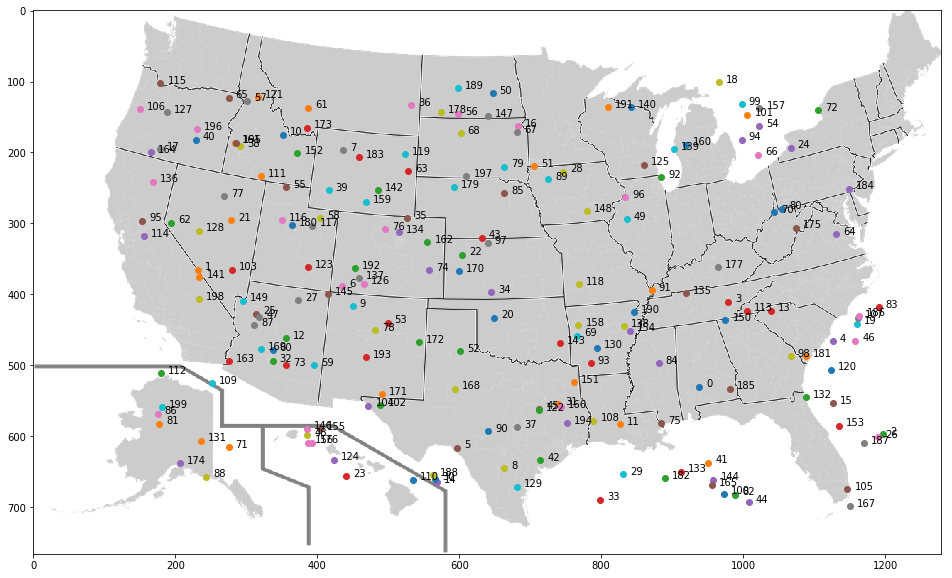

In [16]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)

im = plt.imread("us_map.png")
implot = plt.imshow(im)

count=0
for p in points:
    ax.scatter(p[0], p[1])
    ax.annotate(str(count), (p[0]+10, p[1]))
    count+=1

<p><strong>Define ObjFun and contraints</strong>:</p>

In [17]:
m = Model()

# Create variables

vars = m.addVars(dist.keys(), vtype=GRB.BINARY, name='e')

# edge in opposite direction

for i,j in vars.keys():
    vars[j,i] = vars[i,j] 
    
# Define objective function

m.setObjective(quicksum(vars[i,j]*dist[i,j] for i,j in dist.keys()), GRB.MINIMIZE)

# Add degree-2 constraint

c=m.addConstrs(vars.sum(i,'*') == 2 for i in range(n))

<p><strong>Introducing callbacks and lazy constraints</strong>:</p>

<p><strong>Model.cbGetSolution():</strong>&nbsp;Retrieve values from the new MIP solution. Note that this method can only be invoked when the <code>where</code> value on the callback function is equal to <code>GRB.Callback.MIPSOL</code> or <code>GRB.Callback.MULTIOBJ</code> (see the <a href="https://www.gurobi.com/documentation/8.1/refman/callback_codes.html#sec:CallbackCodes">Callback Codes</a> section for more information).</p>
<p>More details <a href="https://www.gurobi.com/documentation/8.1/refman/py_model_cbgetsolution.html">here</a>.</p>
<p><strong>Model.cbLazy():&nbsp;</strong>Add a new lazy constraint to a MIP model from within a callback function. Note that this method can only be invoked when the <code>where</code> value on the callback function is <code>GRB.Callback.MIPNODE</code> or <code>GRB.Callback.MIPSOL</code> (see the <a href="https://www.gurobi.com/documentation/8.1/refman/callback_codes.html#sec:CallbackCodes">Callback Codes</a> section for more information).</p>
<p>Lazy constraints are typically used when the full set of constraints for a MIP model is too large to represent explicitly. By only including the constraints that are actually violated by solutions found during the branch-and-cut search, it is sometimes possible to find a proven optimal solution while only adding a fraction of the full set of constraints.</p>
<p>You would typically add a lazy constraint by first querying the current node solution (by calling <a href="https://www.gurobi.com/documentation/8.1/refman/py_model_cbgetsolution.html#pythonmethod:Model.cbGetSolution">cbGetSolution</a> from a<code>GRB.CB_MIPSOL</code> callback, or <a href="https://www.gurobi.com/documentation/8.1/refman/py_model_cbgetnoderel.html#pythonmethod:Model.cbGetNodeRel">cbGetNodeRel</a> from a <code>GRB.CB_MIPNODE</code> callback), and then calling <code>cbLazy()</code> to add a constraint that cuts off the solution. Gurobi guarantees that you will have the opportunity to cut off any solutions that would otherwise be considered feasible.</p>
<p>Your callback should be prepared to cut off solutions that violate any of your lazy constraints, including those that have already been added. Node solutions will usually respect previously added lazy constraints, but not always.</p>
<p>Note that you must set the <a href="https://www.gurobi.com/documentation/8.1/refman/lazyconstraints.html#parameter:LazyConstraints">LazyConstraints</a> parameter if you want to use lazy constraints.</p>
<p>More details <a href="https://www.gurobi.com/documentation/8.1/refman/py_model_cblazy.html">here</a></p>
<p>&nbsp;</p>

In [18]:
# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        # pick vars that are one
        selected = tuplelist((i,j) for i,j in model._vars.keys() if vals[i,j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < n:
            # add subtour elimination constraint for every pair of cities in tour
            model.cbLazy(quicksum(model._vars[i,j]
                                  for i,j in itertools.combinations(tour, 2))
                         <= len(tour)-1)


# Given a tuplelist of edges, find the shortest subtour

def subtour(edges):
    unvisited = list(range(n))
    cycle = range(n+1) # initial length has 1 more city
    while unvisited: # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i,j in edges.select(current,'*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

<p><strong>Running the optimizer</strong>:</p>

In [19]:
# Initializing few model params
start_time  = time.time()
m._start_time = start_time
m._runlimit = 12
m._vars = vars
m.Params.lazyConstraints = 1
m._dist = dist
m._n = n

# Stop optimizastion after 12 sec of running time
m.setParam('TimeLimit',m._runlimit)

# Optimize model
m.optimize(subtourelim)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter TimeLimit to 12.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 200 rows, 19900 columns and 39800 nonzeros
Variable types: 0 continuous, 19900 integer (19900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.03s
Presolved: 200 rows, 19900 columns, 39800 nonzeros
Variable types: 0 continuous, 19900 integer (19900 binary)

Root relaxation: objective 7.630689e+03, 302 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7630.68925    0   50          - 7630.68925      -     -    0s
     0     0 7650.31245    0   32          - 7650.31245      -     -    0s
     0     0 7679.45912 

<p><strong>Plot Gurobi Solution</strong>:</p>

In [20]:
vals = m.getAttr('x', vars)
selected = tuplelist((i,j) for i,j in vals.keys() if vals[i,j] > 0.5)

tour = subtour(selected)
assert len(tour) == n

print('')
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g' % m.objVal)
print('')

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
im = plt.imread("us_map.png")
implot = plt.imshow(im)

count=0
for p in points:
    ax.scatter(p[0], p[1])
    ax.annotate(str(count), (p[0]+10, p[1]))
    count+=1
    
x=[points[t][0] for t in tour]
y=[points[t][1] for t in tour]
ax.plot(x, y,'-o')
plt.show()

GurobiError: Unable to retrieve attribute 'x'

<p><strong>Plot Greedy/Local Search Solution</strong>:</p>

In [ ]:
vals = m.getAttr('start', vars)
selected = tuplelist((i,j) for i,j in vals.keys() if vals[i,j] > 0.5)

tour = subtour(selected)
assert len(tour) == n

print('')
print('Optimal tour: %s' % str(tour))
print('')

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
im = plt.imread("us_map.png")
implot = plt.imshow(im)

count=0
for p in points:
    ax.scatter(p[0], p[1])
    ax.annotate(str(count), (p[0]+10, p[1]))
    count+=1
    
x=[points[t][0] for t in tour]
y=[points[t][1] for t in tour]
ax.plot(x, y,'-o')
plt.show()

# 4. Optimization and Heuristics <a name="heuristics"></a>

In [ ]:
# Add the below two lines before running m.optimizer to start MIP with a a greedy solution

#m.update() # needed because we access variable attributes in heuristics
#greedy_heu(m)

# Add the above two lines and the below line before running m.optimizer to start MIP with a greedy and a localized solution

#local_heu(m, submipsize, display=1,sequential=1)

## Greedy Algorithm

A classical <span class="blue bold">construction</span> heuristic for TSP is:
<ul>
    <li>Label all nodes as <span class="blue bold">unvisited</span></li>
    <li>Start from a given node</li>
    <li>Mark node as visited</li>
    <li>Select next node as closest node to current node</li>
    <li>Set current node as new node, <code>repeat</code></li>
</ul>

In [ ]:
lineseparator = '----------------------------------------------------------------------'

def greedy_heu(model):
    '''
    This heuristics starts from node zero, and select a shortest edge to
    move to an unvisited node. Then repeat the process in the new
    terminal
    '''
    start_time = time.time()
    unvisited = list(range(model._n))
    for i,j in model._vars.keys():
        model._vars[i,j].setAttr('Start',0)
        model._vars[i,j]._curX = 0
        current = 0
        totval  = 0
    #select next node within unvisited
    while current in unvisited:
        nextval = 1e100
        nextvar = None
        bextj   = model._n
        for i,j in model._vars.keys().select(current,'*'):
            if j in unvisited:
                curval = model._vars[current,j].getAttr('Obj') 
                if curval < nextval:
                    nextval = curval 
                    nextvar = model._vars[current,j]
                    nextj   = j
    # This may happen if we are not working on a complete set of edges
        if nextvar is None:
            break
        totval += nextval
        assert(j < model._n)
        nextvar.setAttr('Start',1)
        nextvar._curX = 1
        unvisited.remove(current)
        current = nextj
    assert(len(unvisited) >= 1)
    #add last edge to the solution
    if (current,0) in model._vars.keys():
        unvisited.remove(current)
        totval += model._vars[current,0].getAttr('Obj')
        model._vars[current,0].setAttr('Start',1)
        model._vars[current,0]._curX = 1
        #record whether we found a solution or not
    model._tourval = None
    if unvisited:
        print(pycol.Fore.RED + 'Failed to build greedy solution, unvisited %s %.2f seconds' % (str(unvisited),time.time()-start_time))
        print(pycol.Style.RESET_ALL)
    else:
        model._tourval = totval
        print(pycol.Fore.RED)
        print(lineseparator)
        print('Found feasible solution, value %g %.2f seconds' % (totval,time.time()-start_time))
        print(lineseparator)
        print(pycol.Style.RESET_ALL)
    return None

## Local Search

Why would it make sense?
<ul>
    <li>Problems get harder as they grow, the reverse is also true</li>
    <li>If problem has natural <span class="blue bold">pieces</span> we can search in parallel!</li>
</ul>

<ul>
    <li>Each tour segment, of any length, can be used as a partition</li>
    <li>Can work on <span class="blue bold">geometric</span> partitions of the points too</li>
</ul>

In [ ]:
def local_heu(model, maxlen, maxt=10, display=0, sequential=1):
  '''
  This heuristic start from a solution (stored in
  model._vars[i,j]._curX) and fix all variables incident to all nodes
  but for `maxt` of them, and optimize the remaining problem. The
  selection of nodes can be sequential within the current best
  solution (sequential=1) or following node indices (sequential = 0)
  This process is iterated twice the length of the tour
  '''
  #ensure we have a solution
  if (model._tourval is None):
    print('No starting solution stored')
    return None
  #ensure model is big enough
  if (model._n < maxlen):
    print('Sub-problem too small')
    return None
  #stats
  start_time = time.time()
  optimal = 0
  timelimit = 0
  #change parameters
  origt = model.Params.timelimit
  origP = model.Params.outputflag
  origG = model.Params.mipgap
  model.params.timelimit = maxt
  model.params.outputflag = display
  model.params.mipgap = 0.005
  #build sequence
  tour = subtour(tuplelist((i,j) for i,j in model._vars.keys() if model._vars[i,j]._curX > 0.5))
  #print('Initial Tour:' + str(tour))
  assert(len(tour) == model._n)
  #loop in sequence twice
  for i in range(model._n):
    fixed = []
    #fix part of the problem to the current solution
    for j in range(model._n - maxlen):
      k = i + j
      while (k >= model._n):
        k -= model._n
      if sequential:
        k = tour[k]
        assert(k >= 0 and k < model._n)
      #print('Fix node %d i,j %d,%d' % (k,i,j))  
      assert(k >= 0 and k < model._n and k not in fixed)
      fixed.append(k)
      for a,b in model._vars.keys().select(k,'*'):
        model._vars[a,b].setAttr('LB', model._vars[a,b]._curX)
        model._vars[a,b].setAttr('UB', model._vars[a,b]._curX)
    #optimize
    model.optimize(subtourelim)
    if model.Status == GRB.OPTIMAL:
      optimal += 1
    if model.Status == GRB.TIME_LIMIT:
      timelimit += 1
    if model.getAttr('SolCount') == 0:
      print('Failed in local optimization')
      for i,j in model._vars.keys():
        model._vars[i,j].setAttr('LB', 0)
        model._vars[i,j].setAttr('UB', 1)
      model.update()
      break
    if model.getAttr('ObjVal') + 1e-6 < model._tourval:
      for i,j in model._vars.keys():
        if model._vars[i,j].getAttr('X') > 0.5:
          model._vars[i,j]._curX = 1
        else:
          model._vars[i,j]._curX = 0
      model._tourval = model.getAttr('ObjVal')
      print('Improve solution %g %.2f seconds' % (model._tourval,time.time()-start_time))
      tour = subtour(tuplelist((i,j) for i,j in model._vars.keys() if model._vars[i,j]._curX > 0.5))
      #print('Improved Tour:' + str(tour))
    for i,j in model._vars.keys():
      model._vars[i,j].setAttr('LB', 0)
      model._vars[i,j].setAttr('UB', 1)
      model._vars[i,j].setAttr('Start', model._vars[i,j]._curX)
    if (time.time() - model._start_time > model._runlimit):
      break
  #restore model parameter values
  model.params.timelimit = origt
  model.params.outputflag = origP
  model.Params.mipgap = origG
  #display and end
  print(pycol.Fore.RED)
  print(lineseparator)
  print('Final solution %g subproblems %d optimal %d timelimit %d %.2f seconds' % 
         (model._tourval, model._n, optimal, timelimit, time.time()-start_time))
  print(lineseparator)
  print(pycol.Style.RESET_ALL)
  model.update()
  return None

# END OF TUTORIAL 3

***